Multi-Labelled Odors Classification using Neural Networks and Graphic Neural Networks
=======

made by Jina a.k.a SUMIGAMJA

Part 0. Prepare Dataset
-

Data set : Multi-Labelled SMILES Odors dataset\
https://www.kaggle.com/datasets/aryanamitbarsainyan/multi-labelled-smiles-odors-dataset \
Kaggle의 다양한 dataset 중 assignment를 위해 분자가 가지는 'Odor'에 대한 정보가 담긴 dataset을 가져왔다. \
목표하는 바는 분자의 구조 등의 정보를 통해 향기를 예측하는 model을 구축하는 것이다.

해당 데이터는 4983의 데이터와 하나의 input(SMILES)을 가지고 있어, 주어진 SMILES를 토대로 RDkit을 통해 input variable을 확보할 필요가 있었다.

In [3]:
# Packages

from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.autograd.set_detect_anomaly(True) # for error description
torch.manual_seed(42) # 42 is THE MAGIC SEED
#torch.multiprocessing.set_start_method('spawn')

import pyswarms as ps
from pyswarms.utils.functions import single_obj as fs
import random
random.seed(42)

from sklearn import metrics

In [2]:
# From SMILES to descriptors > Thanks to ChatGPT!

# 사용할 서술자 목록
descriptor_names = [desc[0] for desc in Descriptors._descList]

# raw dataset을 읽어옵니다.
raw_data = pd.read_csv('Multi-Labelled_Smiles_Odors_dataset.csv')

# SMILES 열을 가져옵니다.
smiles_list = raw_data.iloc[:, 0].tolist()

# 분자 서술자 계산을 위한 객체 생성
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

# 서술자 값을 저장할 리스트
descriptors_list = []

for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        descriptors = calculator.CalcDescriptors(mol)
        descriptors_list.append(descriptors)
    else:
        descriptors_list.append([None] * len(descriptor_names))  # None일 경우를 대비

# 서술자 DataFrame 생성
descriptors_df = pd.DataFrame(descriptors_list, columns=descriptor_names)

# 최종 DataFrame 생성
df = pd.concat([raw_data.iloc[:, [0]], descriptors_df, raw_data.iloc[:, 2:]], axis=1)

# 최종 결과를 CSV 파일로 저장
df.to_csv('final_descriptors.csv', index=False)

KeyboardInterrupt: 

이제 final_descriptors.csv 파일에 Neural Network를 위한 dataset이 준비되었다. Thanks to ChatGPT~ \
\
후술할 Part 1에서는 Neural Network(NN)을 이용하여, Part 2에는 Graphic Neural Network(GNN)를 이용하여 학습을 진행할 것이다. \
결론부에서는 NN과 GNN의 결과를 비교하며, 어떤 방법론이 어떠한 특징을 통해 어떤 장단점을 가지는지 논하도록 하겠다.



Part 1. Neural Networks (NNs)
-

In [4]:
# Let's start!

df = pd.read_csv('./final_descriptors.csv')
# print(df.iloc[:,-138:].head())
df = df.dropna(axis = 0, how = 'any') # Eliminate rows including NaN data
train, validation, test = np.split(df.sample(frac = 1, random_state = 42),
                                   [int(0.8 * len(df)), int(0.9 * len(df))])
print(f"Train : {len(train)} | Validate : {len(validation)} | Test : {len(test)}")

Train : 3900 | Validate : 487 | Test : 488


/PROGRAMS/miniconda3/envs/Torch/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
# Custom Dataset

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df):   
        self.df = df

        self.y = torch.tensor(self.df.iloc[:,-138:].values) # 'Odors' columns
        self.x = torch.tensor(self.df.iloc[:,1:-138].fillna(0).values) # 'Molecular descriptors' columns

        self.y = self.y.float().reshape(-1, 138)
        self.x = self.x.float().reshape(-1, self.x.shape[-1])
        print(self.x.shape)

        return

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx]

train_dataset = CustomDataset(train)
validation_dataset = CustomDataset(validation)
test_dataset = CustomDataset(test)

torch.Size([3900, 217])
torch.Size([487, 217])
torch.Size([488, 217])


In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 256, num_workers = 1)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 256, num_workers = 1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256, num_workers = 1)  

In [7]:
import Cycle # Model & Cycle definition in here

In [8]:
def objective_function(input_array):
    
    # print(input_array)
    input_array = input_array.flatten()
    
    parameters = {
        'in_size' : 217,
        'out_size' : 138, 
        'lr' : input_array[0],
        'hidden_size' : int(input_array[1]),
        'num_hidden_layer' : int(input_array[2]),
        'pos_weight' : input_array[3]
    }

    cycle = Cycle.Cycle(
            parameters = parameters,
            loaders = (train_loader, validation_loader, test_loader)
    )

    result = cycle.run(50)

    print(result)
    
    return np.array([result])
    
bounds = (np.array([1E-2, 128, 4, 2]),
          np.array([1E-4, 512, 16, 128]))

options = {'c1' : 0.5, 'c2' : 0.3, 'w' : 0.9}

optimizer = ps.single.GlobalBestPSO(
    n_particles = 6,
    dimensions = 4,
    bounds = bounds,
    options = options
)

In [9]:
stats = optimizer.optimize(
    objective_function,
    iters = 50,
    n_processes = 6 #: 노드 사용
)

print(stats)

2025-02-03 12:32:14,544 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|                                                    |0/50


RuntimeError: CUDA error: initialization error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
parameters = {
    'in_size' : 217,
    'out_size' : 138, 
    'lr' : 1E-2,
    'hidden_size' : 236,
    'num_hidden_layer' : 7,
    'pos_weight' : 42
}

model = Cycle.Cycle(
        parameters = parameters,
        loaders = (train_loader, validation_loader, test_loader),
        gpuid = 0
)

In [11]:
model.run(100, verbose = True)

Epoch : 00000 | Trn. Loss : 40629015457655.430 | Val. Loss : 5.283
Epoch : 00001 | Trn. Loss : 17053523416.986 | Val. Loss : 38.129
Epoch : 00002 | Trn. Loss : 181918614096.332 | Val. Loss : 25.306
Epoch : 00003 | Trn. Loss : 14160409.413 | Val. Loss : 99.999
Epoch : 00004 | Trn. Loss : 422808191066.826 | Val. Loss : 6.653
Epoch : 00005 | Trn. Loss : 21516694896.347 | Val. Loss : 7.862
Epoch : 00006 | Trn. Loss : 1239870104056.875 | Val. Loss : 2.742
Epoch : 00007 | Trn. Loss : 2417715319.406 | Val. Loss : 13.984
Epoch : 00008 | Trn. Loss : 7129571946.684 | Val. Loss : 153.791
Epoch : 00009 | Trn. Loss : 179007778672.437 | Val. Loss : 361.263
Epoch : 00010 | Trn. Loss : 376237843.638 | Val. Loss : 152.240
Epoch : 00011 | Trn. Loss : 94170831.757 | Val. Loss : 107.486
Epoch : 00012 | Trn. Loss : 54324886.943 | Val. Loss : 179.143
Epoch : 00013 | Trn. Loss : 41739092320649.891 | Val. Loss : 42.679
Epoch : 00014 | Trn. Loss : 60380394.234 | Val. Loss : 454.390
Epoch : 00015 | Trn. Loss : 

1.3613179922103882

In [12]:
# Model Performance Check

with torch.no_grad():
    model.model.eval()

    test_loss = 0.0
    pred = [] ; true = []

    for x, y in test_loader:
        out = model.model(x.to(f'cuda:{model.gpuid}'))
        test_loss += model.criterion(out, y.to(torch.float).to(f'cuda:{model.gpuid}'))

        out = torch.nn.functional.sigmoid(out)
        
        pred.append(out.cpu().numpy())
        true.append(y.cpu().numpy())

test_loss = test_loss.item() / len(test_loader)
pred = np.concatenate(pred)
true = np.concatenate(true)

pred = pred.astype(int)
true = true.astype(int)

print(pred)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


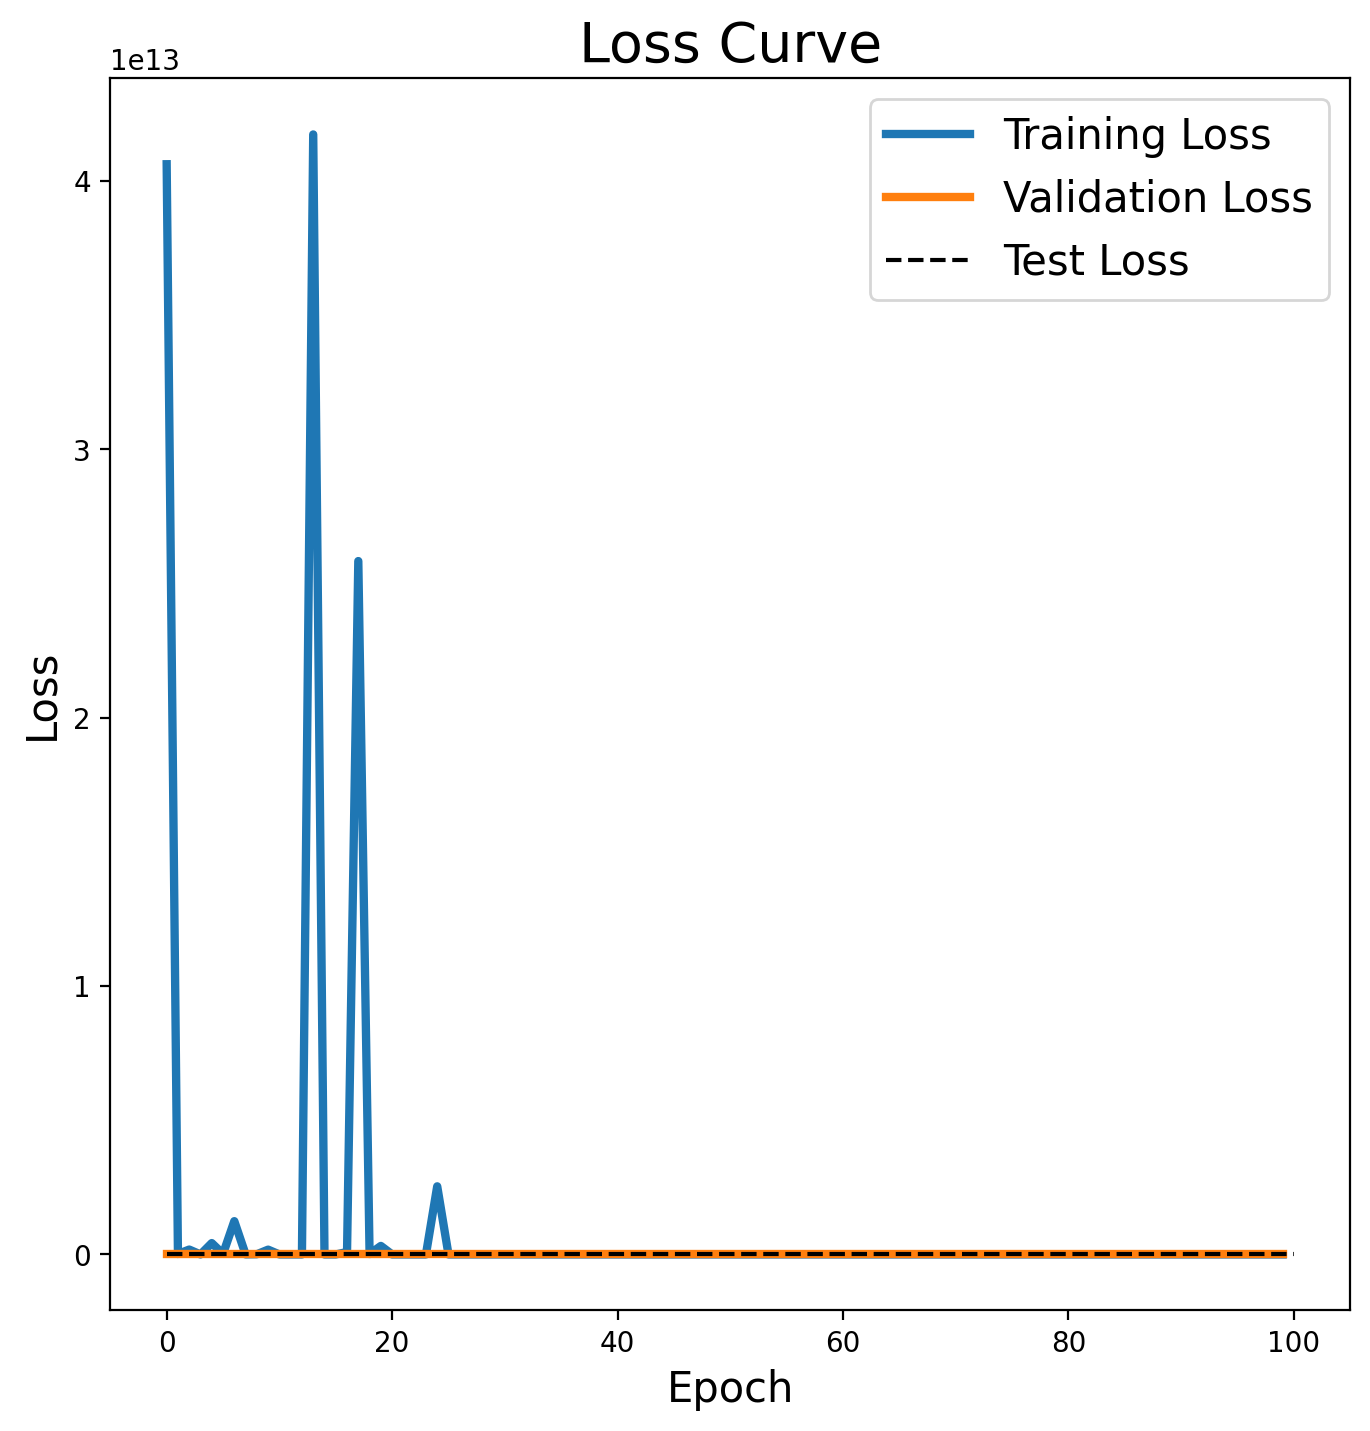

In [13]:
# Loss curve Plotting

fig, ax = plt.subplots(1, 1, figsize = (8, 8), dpi = 200)

ax.set_xlabel("Epoch", fontsize = 15)
ax.set_ylabel("Loss", fontsize = 15)
ax.set_title("Loss Curve", fontsize = 20)

ax.plot(range(100), model.trn_loss, linewidth = 3, label = 'Training Loss')
ax.plot(range(100), model.val_loss, linewidth = 3, label = 'Validation Loss')
ax.hlines(test_loss, 0, 100, linestyle = '--', color = 'k', label = 'Test Loss')
#ax.set_ylim((0,0.3))

ax.legend(fontsize = 15)
plt.show()

In [14]:
print(metrics.multilabel_confusion_matrix(true, pred))

[[[477   0]
  [ 11   0]]

 [[477   0]
  [ 11   0]]

 [[471   0]
  [ 17   0]]

 [[484   0]
  [  4   0]]

 [[477   0]
  [ 11   0]]

 [[476   0]
  [ 12   0]]

 [[481   0]
  [  7   0]]

 [[459   0]
  [ 29   0]]

 [[476   0]
  [ 12   0]]

 [[479   0]
  [  9   0]]

 [[456   0]
  [ 32   0]]

 [[476   0]
  [ 12   0]]

 [[483   0]
  [  5   0]]

 [[487   0]
  [  1   0]]

 [[469   0]
  [ 19   0]]

 [[482   0]
  [  6   0]]

 [[483   0]
  [  5   0]]

 [[477   0]
  [ 11   0]]

 [[477   0]
  [ 11   0]]

 [[471   0]
  [ 17   0]]

 [[483   0]
  [  5   0]]

 [[472   0]
  [ 16   0]]

 [[465   0]
  [ 23   0]]

 [[481   0]
  [  7   0]]

 [[483   0]
  [  5   0]]

 [[485   0]
  [  3   0]]

 [[467   0]
  [ 21   0]]

 [[483   0]
  [  5   0]]

 [[483   0]
  [  5   0]]

 [[483   0]
  [  5   0]]

 [[449   0]
  [ 39   0]]

 [[479   0]
  [  9   0]]

 [[488   0]
  [  0   0]]

 [[478   0]
  [ 10   0]]

 [[477   0]
  [ 11   0]]

 [[482   0]
  [  6   0]]

 [[477   0]
  [ 11   0]]

 [[481   0]
  [  7   0]]

 [[481   0]


In [16]:
f1_score = metrics.f1_score(true, pred, average = 'weighted')
f1_score

/PROGRAMS/miniconda3/envs/Torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


0.0